In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, GlobalAveragePooling2D, Dropout, BatchNormalization
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.callbacks import Callback


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
train_dir = '/content/drive/MyDrive/Ujicoba/Dataset3/Train'
test_dir = '/content/drive/MyDrive/Ujicoba/Dataset3/Test'


In [ ]:
# Parameter gambar
image_height = 224  # Ukuran input standar untuk ResNet50
image_width = 224
num_classes = 4

# Data augmentation (ditingkatkan)
train_datagen = ImageDataGenerator(
    preprocessing_function=tf.keras.applications.resnet50.preprocess_input,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'  # Untuk mengisi piksel yang kosong setelah transformasi
)

test_datagen = ImageDataGenerator(
    preprocessing_function=tf.keras.applications.resnet50.preprocess_input
)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(image_height, image_width),
    batch_size=32,
    class_mode='categorical'
)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(image_height, image_width),
    batch_size=32,
    class_mode='categorical'
)


Found 779 images belonging to 4 classes.
Found 332 images belonging to 4 classes.


In [ ]:
class AccuracyStopping(Callback):
    def __init__(self, monitor='accuracy', value=0.85, verbose=0):
        super(Callback, self).__init__()
        self.monitor = monitor
        self.value = value
        self.verbose = verbose

    def on_epoch_end(self, epoch, logs={}):
        current = logs.get(self.monitor)
        val_current = logs.get('val_' + self.monitor)  # Monitor juga val_accuracy

        if current is None or val_current is None:
            return

        if current > self.value and val_current > self.value:
            if self.verbose > 0:
                print(f"\nEpoch {epoch+1}: Early stopping since {self.monitor} and val_{self.monitor} are above {self.value}")
            self.model.stop_training = True


accuracy_stopping = AccuracyStopping(monitor='accuracy', value=0.85, verbose=1)


In [ ]:
#Muat ResNet50
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(image_height, image_width, 3))

# Bekukan lapisan dasar
for layer in base_model.layers:
    layer.trainable = False

# Buat model
model = Sequential([
    base_model,
    GlobalAveragePooling2D(),
    Dense(256, activation='relu'),
    BatchNormalization(),
    Dropout(0.5),  # Dropout untuk mengurangi overfitting
    Dense(num_classes, activation='softmax')
])

# Kompilasi model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])


94765736/94765736 [==============================] - 1s 0us/step


In [ ]:
# Latih model
history = model.fit(
    train_generator,
    steps_per_epoch=len(train_generator),
    epochs=400,
    validation_data=test_generator,
    validation_steps=len(test_generator),
    callbacks=[accuracy_stopping]
)

Epoch 1/400
25/25 [==============================] - 382s 15s/step - loss: 1.2230 - accuracy: 0.5315 - val_loss: 0.8438 - val_accuracy: 0.5934
Epoch 2/400
25/25 [==============================] - 16s 663ms/step - loss: 0.9089 - accuracy: 0.6110 - val_loss: 0.7724 - val_accuracy: 0.6325
Epoch 3/400
25/25 [==============================] - 17s 663ms/step - loss: 0.7804 - accuracy: 0.6650 - val_loss: 1.0156 - val_accuracy: 0.5813
Epoch 4/400
25/25 [==============================] - 17s 683ms/step - loss: 0.7475 - accuracy: 0.6727 - val_loss: 0.8953 - val_accuracy: 0.5331
Epoch 5/400
25/25 [==============================] - 17s 657ms/step - loss: 0.7277 - accuracy: 0.6881 - val_loss: 0.7749 - val_accuracy: 0.6235
Epoch 6/400
25/25 [==============================] - 16s 659ms/step - loss: 0.7000 - accuracy: 0.6804 - val_loss: 0.7586 - val_accuracy: 0.6446
Epoch 7/400
25/25 [==============================] - 17s 679ms/step - loss: 0.6722 - accuracy: 0.6983 - val_loss: 0.8123 - val_accuracy: 

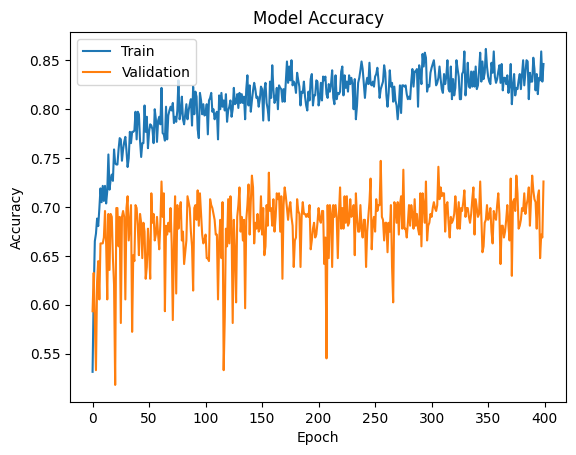

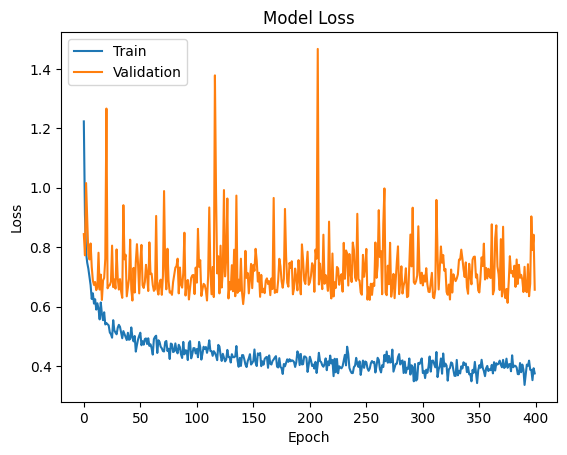

In [ ]:
# Plot grafik akurasi
import matplotlib.pyplot as plt

plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Plot grafik loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

In [ ]:
# Path untuk menyimpan model
saved_model_dir = '/content/drive/MyDrive/Ujicoba/Dataset3/SaveModel/UseRestNet1'
tflite_model_path = '/content/drive/MyDrive/Ujicoba/Dataset3/SaveModel/UseRestNet1/ModelSkinSavvy.tflite'

# Simpan model dalam format SavedModel
model.save(saved_model_dir + 'ModelSkinSavvy')  # Tambahkan nama model di sini

# Konversi model ke TFLite
converter = tf.lite.TFLiteConverter.from_saved_model(saved_model_dir + 'ModelSkinSavvy')  # Gunakan path lengkap
tflite_model = converter.convert()

# Simpan model TFLite
with open(tflite_model_path, 'wb') as f:
    f.write(tflite_model)

print("Model SavedModel dan TFLite (ModelSkinSavvy) berhasil disimpan di:", saved_model_dir)

Model SavedModel dan TFLite (ModelSkinSavvy) berhasil disimpan di: /content/drive/MyDrive/Ujicoba/Dataset3/SaveModel/UseRestNet1


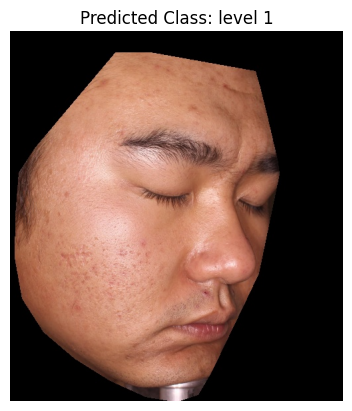

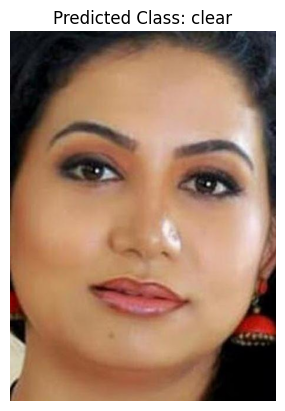

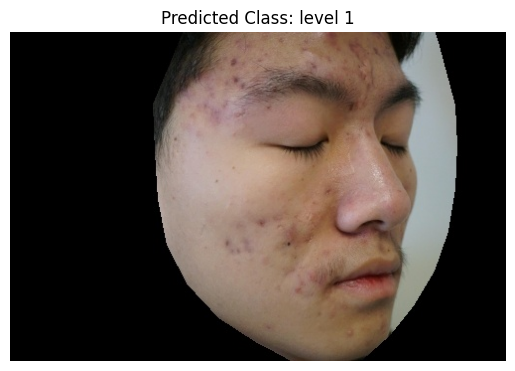

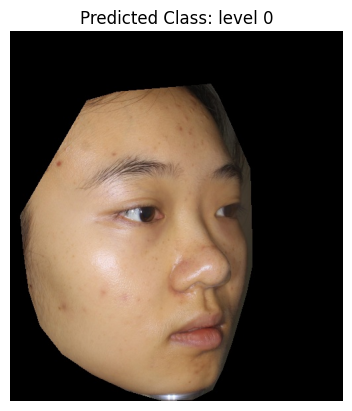

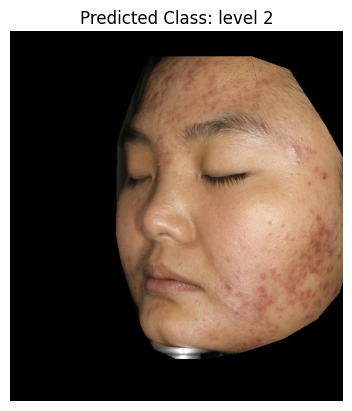

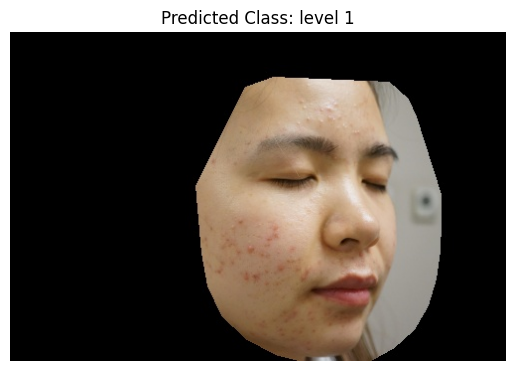

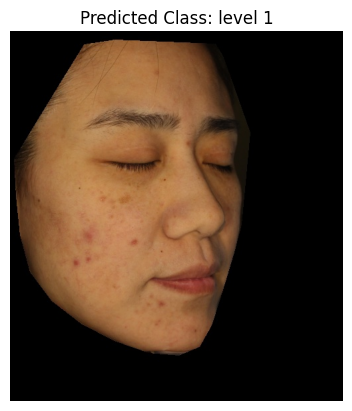

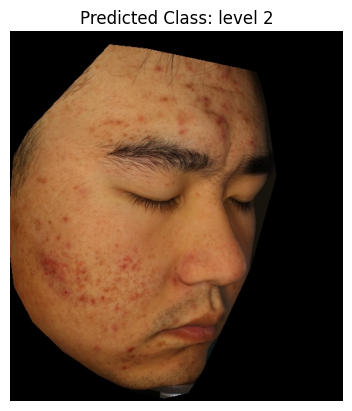

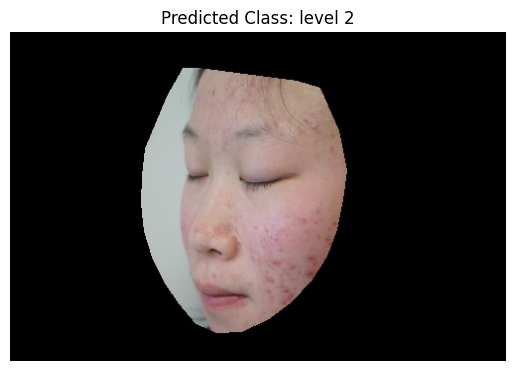

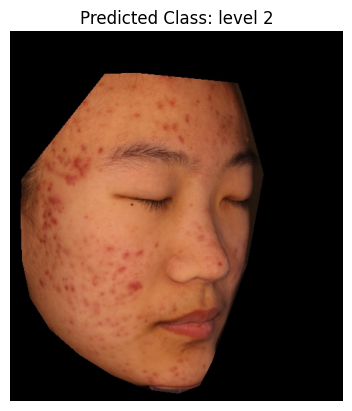

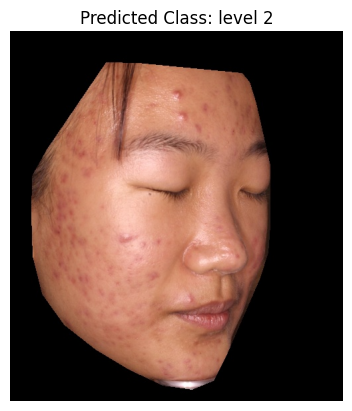

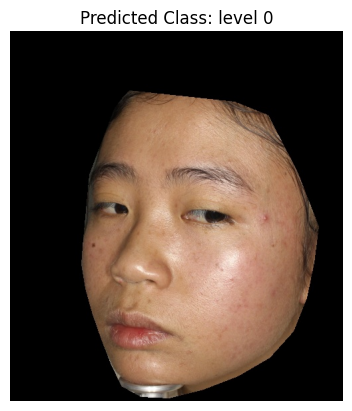

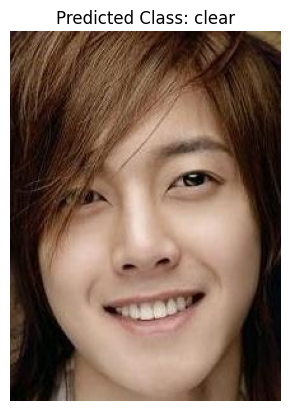

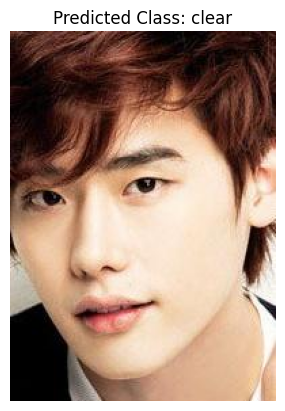

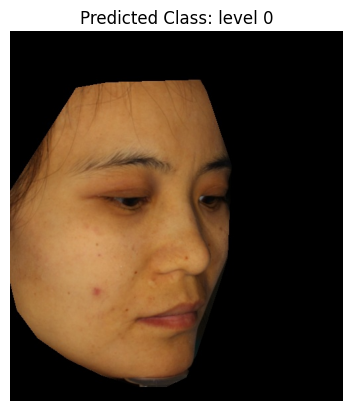

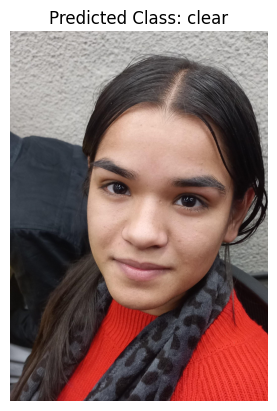

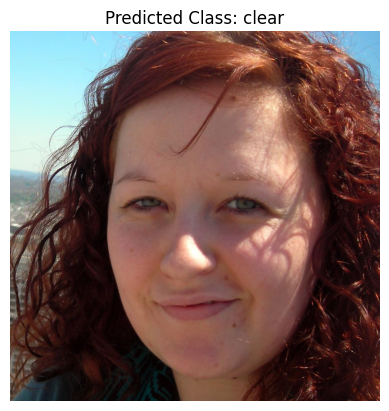

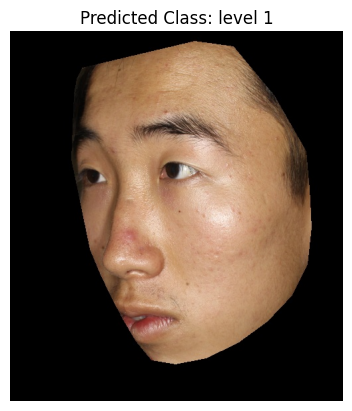

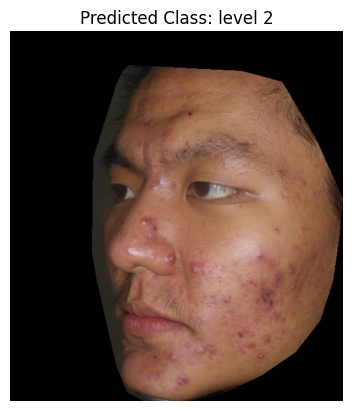

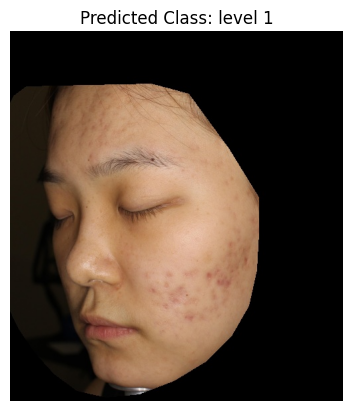

In [ ]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing import image
import os

# Load the TFLite model
tflite_model_path = '/content/drive/MyDrive/Ujicoba/Dataset3/SaveModel/UseRestNet1/ModelSkinSavvy.tflite'
interpreter = tf.lite.Interpreter(model_path=tflite_model_path)
interpreter.allocate_tensors()

# Define the class labels
class_labels = ['clear', 'level 0', 'level 1', 'level 2']

# Define the directory of test images
test_images_dir = '/content/drive/MyDrive/Ujicoba/Dataset3/Uji'

# Function to load and preprocess image
def load_and_preprocess_image(img_path, target_size=(224, 224)):
    img = image.load_img(img_path, target_size=target_size)
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array = tf.keras.applications.resnet50.preprocess_input(img_array)
    return img_array

# Get input and output tensors.
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

# Get the list of test images
test_images = [os.path.join(test_images_dir, img) for img in os.listdir(test_images_dir) if img.endswith(('png', 'jpg', 'jpeg'))]

# Function to plot image with prediction
def plot_image_with_prediction(img_path):
    img_array = load_and_preprocess_image(img_path)

    interpreter.set_tensor(input_details[0]['index'], img_array)
    interpreter.invoke()
    prediction = interpreter.get_tensor(output_details[0]['index'])

    predicted_class = class_labels[np.argmax(prediction)]

    img = image.load_img(img_path)
    plt.imshow(img)
    plt.title(f'Predicted Class: {predicted_class}')
    plt.axis('off')
    plt.show()

# Loop through and display each test image with prediction
for img_path in test_images:
    plot_image_with_prediction(img_path)